In [1]:
%%html
<style type='text/css'>
.CodeMirror{
    font-family: Consolas;
    font-size: 15px;
}

div.output_area pre {
    font-family: Consolas;
    font-size: 12px;
}
</style>

In [2]:
import pandas as pd
import os
import torch
import seaborn as sns
import numpy as np

import matplotlib

from tqdm.notebook import tqdm, tqdm_notebook
from datetime import datetime, timedelta

# path_dataset = r"D:\Datasets\mimic\mimic-iii-clinical-database-1.4"
path_dataset = r"/data/data2/041/datasets/mimic-iii-clinical-database-1.4"
list_csvgz = [f for f in os.listdir(path_dataset) if f[-6:]=="csv.gz"]
list_csvgz

['DRGCODES.csv.gz',
 'LABEVENTS.csv.gz',
 'PATIENTS.csv.gz',
 'D_ITEMS.csv.gz',
 'DIAGNOSES_ICD.csv.gz',
 'CAREGIVERS.csv.gz',
 'SERVICES.csv.gz',
 'CPTEVENTS.csv.gz',
 'OUTPUTEVENTS.csv.gz',
 'D_LABITEMS.csv.gz',
 'D_ICD_DIAGNOSES.csv.gz',
 'LABEVENTS_NEW_remove_duplicate_edges.csv.gz',
 'CALLOUT.csv.gz',
 'ADMISSIONS.csv.gz',
 'D_CPT.csv.gz',
 'INPUTEVENTS_MV.csv.gz',
 'D_LABITEMS_NEW.csv.gz',
 'PROCEDUREEVENTS_MV.csv.gz',
 'ADMISSIONS_NEW.csv.gz',
 'PRESCRIPTIONS.csv.gz',
 'NOTEEVENTS.csv.gz',
 'DATETIMEEVENTS.csv.gz',
 'MICROBIOLOGYEVENTS.csv.gz',
 'ICUSTAYS.csv.gz',
 'D_ICD_PROCEDURES.csv.gz',
 'LABEVENTS_NEW.csv.gz',
 'CHARTEVENTS.csv.gz',
 'TRANSFERS.csv.gz',
 'PROCEDURES_ICD.csv.gz',
 'INPUTEVENTS_CV.csv.gz']

In [4]:
[f for f in list_csvgz if f[-10:-7]=='NEW']

['D_LABITEMS_NEW.csv.gz', 'ADMISSIONS_NEW.csv.gz', 'LABEVENTS_NEW.csv.gz']

# ADMISSIONS

In [3]:
df_admissions = pd.read_csv(os.path.join(path_dataset, "ADMISSIONS.csv.gz"))

# Convert columns to datetime
df_admissions["ADMITTIME"] = pd.to_datetime(df_admissions["ADMITTIME"], format="%Y-%m-%d %H:%M:%S")
df_admissions["DISCHTIME"] = pd.to_datetime(df_admissions["DISCHTIME"], format="%Y-%m-%d %H:%M:%S")

df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   object        
 6   ADMISSION_TYPE        58976 non-null  object        
 7   ADMISSION_LOCATION    58976 non-null  object        
 8   DISCHARGE_LOCATION    58976 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  MARITAL_STATUS        48848 non-null  object        
 13  ETHNICITY       

In [4]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


## STAYTIME hist

In [5]:
df_admissions["STAYTIME"] = (df_admissions["DISCHTIME"] - df_admissions["ADMITTIME"]) / timedelta(days=1)
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,STAYTIME
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1.144444
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.496528
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,6.768056
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2.856944
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3.534028


<Axes: title={'center': 'Statistics on length of hospital stay'}, ylabel='Frequency'>

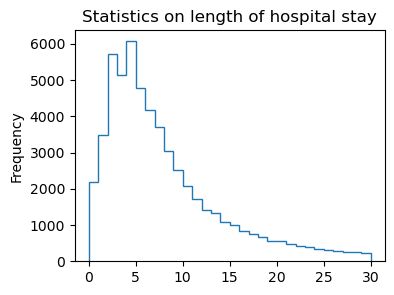

In [6]:
df_admissions.STAYTIME.plot(kind='hist', bins=30, range=(0, 30), histtype="step", figsize=(4, 3), title="Statistics on length of hospital stay")

<Axes: title={'center': 'Statistics on length of hospital stay (DEATH)'}, ylabel='Frequency'>

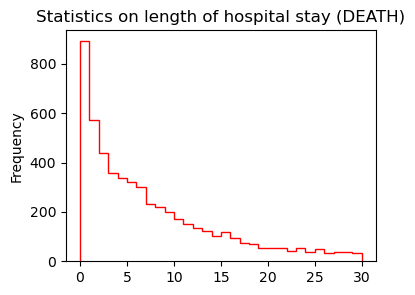

In [7]:
df_admissions[df_admissions.DEATHTIME.notnull()].STAYTIME.plot(kind='hist', bins=30, range=(0, 30), histtype="step", figsize=(4, 3), cmap="autumn", title="Statistics on length of hospital stay (DEATH)")

## Unique mapping

In [8]:
# Create a mapping from unique hadm_id indices to range [0, num_hadm_nodes):
unique_hadm_id = df_admissions.HADM_ID.sort_values().unique()
unique_hadm_id = pd.DataFrame(data={
    'HADM_ID': unique_hadm_id,
    'mappedID': pd.RangeIndex(len(unique_hadm_id)),
})
unique_hadm_id.head()

,HADM_ID,mappedID
0,100001,0
1,100003,1
2,100006,2
3,100007,3
4,100009,4


## Node features

following columns are str type, which need to be remapped:

- ADMISSION_TYPE
- ADMISSION_LOCATION
- DISCHARGE_LOCATION
- INSURANCE
- LANGUAGE
- RELIGION
- MARITAL_STATUS
- ETHNICITY

Note: 

- some columns need to fill na!
- Not all columns above will be used as node_feature, because some columns
  - will cause infomation-leak problem
  - are not availabel until this hadm_id discharge

In [9]:
list_str_type_columns = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']

for c in list_str_type_columns:
    m = df_admissions[c].value_counts()
    m = pd.Series(index=m.index, data=range(1, len(m)+1))
    df_admissions[c] = df_admissions[c].map(m)

values_fillna = {}
for c in list_str_type_columns:
    values_fillna[c] = 0  # use 0 to fill na

df_admissions.fillna(value=values_fillna, inplace=True)

df_admissions.tail()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,STAYTIME
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,1,3,1,2,1.0,2.0,2.0,1,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1,2.742361
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,1,3,5,1,1.0,1.0,3.0,1,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1,0.548611
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,3,2,2,2,1.0,2.0,1.0,1,NaN,NaN,RENAL CANCER/SDA,0,1,8.203472
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,1,1,3,2,1.0,1.0,1.0,1,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0,41.445833
58975,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,1,3,1,2,1.0,1.0,1.0,1,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,1.607639


In [15]:
df_admissions.to_csv(os.path.join(path_dataset, "ADMISSIONS_NEW.csv.gz"))

# DIAGNOSES_ICD

In [10]:
df_diagnoses_icd = pd.read_csv(os.path.join(path_dataset, "DIAGNOSES_ICD.csv.gz"))
df_diagnoses_icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [11]:
df_diagnoses_icd.ICD9_CODE.value_counts()

4019     20703
4280     13111
42731    12891
41401    12429
5849      9119
         ...  
1270         1
E9659        1
71926        1
9593         1
20930        1
Name: ICD9_CODE, Length: 6984, dtype: int64

In [13]:
query_subject_id = 250
df_diagnoses_icd[df_diagnoses_icd.SUBJECT_ID == query_subject_id].merge(df_d_diagnoses_icd, on="ICD9_CODE", how='left')

,ROW_ID_x,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y,SHORT_TITLE,LONG_TITLE
0,3051,250,124271,1.0,0382,651,Pneumococcal septicemia,Pneumococcal septicemia [Streptococcus pneumon...
1,3052,250,124271,2.0,78552,12991,Septic shock,Septic shock
2,3053,250,124271,3.0,51881,5279,Acute respiratry failure,Acute respiratory failure
3,3054,250,124271,4.0,481,5500,Pneumococcal pneumonia,Pneumococcal pneumonia [Streptococcus pneumoni...
4,3055,250,124271,5.0,5849,5908,Acute kidney failure NOS,"Acute kidney failure, unspecified"
5,3056,250,124271,6.0,78551,12990,Cardiogenic shock,Cardiogenic shock
6,3057,250,124271,7.0,9982,12389,Accidental op laceration,Accidental puncture or laceration during a pro...
7,3058,250,124271,8.0,1970,2061,Secondary malig neo lung,Secondary malignant neoplasm of lung
8,3059,250,124271,9.0,19889,2080,Secondary malig neo NEC,Secondary malignant neoplasm of other specifie...
9,3060,250,124271,10.0,99592,11404,Severe sepsis,Severe sepsis


## Statistical analysis of icd-9 entry number per hadm_id

10 maybe a good choice.

mean: 11.03918543136191 
 std: 6.466180243627583


<Axes: title={'center': 'Statistical analysis of icd-9 entry number per hadm_id'}, ylabel='Frequency'>

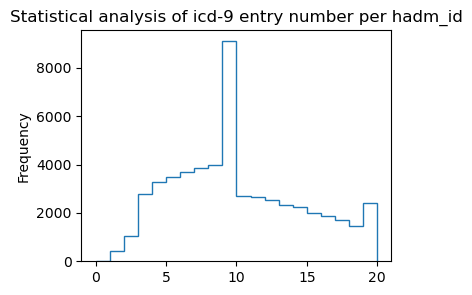

In [14]:
ser_icd9_entry_number_per_hadm_id = df_diagnoses_icd.groupby('HADM_ID').apply(lambda x: x.shape[0])
print(f"mean: {ser_icd9_entry_number_per_hadm_id.mean()}", "\n", f"std: {ser_icd9_entry_number_per_hadm_id.std()}")
ser_icd9_entry_number_per_hadm_id.plot(kind='hist', bins=20, range=(0, 20), histtype="step", figsize=(4, 3), title="Statistical analysis of icd-9 entry number per hadm_id")

# D_LABITEMS

In [10]:
df_d_labitems = pd.read_csv(os.path.join(path_dataset, "D_LABITEMS.csv.gz"))
df_d_labitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      753 non-null    int64 
 1   ITEMID      753 non-null    int64 
 2   LABEL       753 non-null    object
 3   FLUID       753 non-null    object
 4   CATEGORY    753 non-null    object
 5   LOINC_CODE  585 non-null    object
dtypes: int64(2), object(4)
memory usage: 35.4+ KB


In [11]:
df_d_labitems.head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


## Unique mapping

In [12]:
# Create a mapping from unique ITEMID indices to range [0, num_hadm_nodes):
unique_item_id = df_d_labitems.ITEMID.sort_values().unique()
unique_item_id = pd.DataFrame(data={
    'ITEMID': unique_item_id,
    'mappedID': pd.RangeIndex(len(unique_item_id)),
})
unique_item_id.head()

,ITEMID,mappedID
0,50800,0
1,50801,1
2,50802,2
3,50803,3
4,50804,4


## Node features

In [13]:
list_str_type_columns = ['FLUID', 'CATEGORY']

for c in list_str_type_columns:
    m = df_d_labitems[c].value_counts()
    m = pd.Series(index=m.index, data=range(1, len(m)+1))
    df_d_labitems[c] = df_d_labitems[c].map(m)

df_d_labitems.head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,7,1,26447-3
1,547,51347,Eosinophils,7,1,26451-5
2,548,51348,"Hematocrit, CSF",7,1,30398-2
3,549,51349,Hypersegmented Neutrophils,7,1,26506-6
4,550,51350,Immunophenotyping,7,1,NaN


In [14]:
df_d_labitems.to_csv(os.path.join(path_dataset, "D_LABITEMS_NEW.csv.gz"))

# LABEVENTS

In [19]:
df_labevents = pd.read_csv(os.path.join(path_dataset, "LABEVENTS.csv.gz"))
df_labevents.dropna(subset=['HADM_ID', 'ITEMID'], inplace=True)
df_labevents.sort_values(by=["HADM_ID", "ITEMID"], inplace=True)
df_labevents["CHARTTIME"] = pd.to_datetime(df_labevents["CHARTTIME"], format="%Y-%m-%d %H:%M:%S")  # Convert columns to datetime
df_labevents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22245034 entries, 22704987 to 19982158
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   ROW_ID      int64         
 1   SUBJECT_ID  int64         
 2   HADM_ID     float64       
 3   ITEMID      int64         
 4   CHARTTIME   datetime64[ns]
 5   VALUE       object        
 6   VALUENUM    float64       
 7   VALUEUOM    object        
 8   FLAG        object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.7+ GB


In [20]:
df_labevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
22704987,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN
22695648,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN
22695649,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN
22601483,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN
22695650,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.0,mEq/L,abnormal


## Non-value type labitems

In [21]:
df_labevents[df_labevents.VALUENUM.isnull()]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
22704997,22441098,58526,100001.0,51519,2117-09-11 08:53:00,NONE,NaN,NaN,NaN
22714857,22441179,58526,100001.0,51519,2117-09-12 08:41:00,NONE,NaN,NaN,NaN
22734094,22441227,58526,100001.0,51519,2117-09-13 08:21:00,NONE,NaN,NaN,NaN
22744021,22441268,58526,100001.0,51519,2117-09-14 10:08:00,NONE,NaN,NaN,NaN
21366480,21885268,54610,100003.0,50800,2150-04-17 18:12:00,ART,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16641530,16833748,27200,199998.0,51508,2119-02-18 19:49:00,Yellow,NaN,NaN,NaN
16610981,16833959,27200,199998.0,51516,2119-02-22 09:32:00,21-50,NaN,#/hpf,abnormal
16610982,16833960,27200,199998.0,51519,2119-02-22 09:32:00,NONE,NaN,NaN,NaN
19982108,19961377,40370,199999.0,51519,2136-04-04 22:45:00,NONE,NaN,NaN,NaN


In [22]:
grouped_by_itemid_value_type_only = df_labevents[df_labevents.VALUENUM.notnull()].groupby("ITEMID")  # Filter out non-value type labitems
grouped_by_itemid_not_value_type = df_labevents[df_labevents.VALUENUM.isnull()].groupby("ITEMID")  # Filter out non-value type labitems

In [23]:
set_itemid_value_type = list(grouped_by_itemid_value_type_only.groups.keys())
set_itemid_not_value_type = list(grouped_by_itemid_not_value_type.groups.keys())

set_itemid_pure_value_type = np.setdiff1d(set_itemid_value_type, set_itemid_not_value_type)  # pure value type itemids
set_itemid_mixed_value_type = np.setdiff1d(set_itemid_value_type, set_itemid_pure_value_type)  # mix value type itemids
set_itemid_pure_non_value_type = np.setdiff1d(set_itemid_not_value_type, set_itemid_mixed_value_type)  # pure value type itemids

set_itemid_pure_non_value_type

array([50800, 50812, 50827, 50828, 50829, 50845, 50858, 50859, 50871,
       50872, 50873, 50874, 50875, 50876, 50879, 50880, 50886, 50887,
       50901, 50913, 50918, 50919, 50920, 50932, 50933, 50937, 50938,
       50939, 50940, 50941, 50942, 50943, 50944, 50948, 50955, 50959,
       50975, 50979, 50999, 51017, 51056, 51071, 51074, 51075, 51079,
       51085, 51086, 51089, 51090, 51091, 51092, 51096, 51103, 51134,
       51135, 51141, 51142, 51145, 51147, 51151, 51153, 51154, 51155,
       51156, 51157, 51158, 51159, 51161, 51167, 51171, 51172, 51173,
       51177, 51178, 51179, 51182, 51183, 51187, 51189, 51190, 51191,
       51192, 51193, 51195, 51197, 51198, 51201, 51207, 51211, 51213,
       51215, 51216, 51217, 51219, 51220, 51230, 51231, 51234, 51235,
       51236, 51238, 51239, 51242, 51243, 51246, 51247, 51252, 51258,
       51260, 51261, 51262, 51266, 51268, 51278, 51286, 51287, 51290,
       51291, 51292, 51293, 51294, 51295, 51296, 51303, 51304, 51305,
       51306, 51307,

### Pure non-value type itemid

Need to re-map by catagrory.

In [24]:
df_labevents[df_labevents.ITEMID == 51374]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
26603510,26254618,87259,100747.0,51374,2109-12-04 12:00:00,NEEDLE,NaN,NaN,NaN
21112893,20783712,46641,102672.0,51374,2164-08-27 13:44:00,NEEDLE,NaN,NaN,NaN
7442947,7380863,11838,102892.0,51374,2137-05-14 14:21:00,RHOMBOID,NaN,NaN,NaN
27380460,27091246,93838,102946.0,51374,2106-09-28 22:08:00,RHOMBOID,NaN,NaN,NaN
8482664,8367295,13457,103720.0,51374,2189-09-06 10:02:00,NEEDLE,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
23943842,24222015,71743,196558.0,51374,2107-07-09 14:37:00,NEEDLE,NaN,NaN,NaN
19269887,19246689,31516,197262.0,51374,2197-07-25 17:11:00,RHOMBOID,NaN,NaN,NaN
18612999,18804470,30601,197881.0,51374,2141-05-27 09:15:00,NEEDLE,NaN,NaN,NaN
18613004,18804476,30601,197881.0,51374,2141-05-27 11:14:00,NEEDLE,NaN,NaN,NaN


In [25]:
s = df_labevents[df_labevents.ITEMID == 51374].VALUE.value_counts()
m = pd.Series(index=s.index, data=range(1, len(s)+1))
m

NEEDLE      1
RHOMBOID    2
ROD         3
dtype: int64

In [26]:
for itemid in tqdm(set_itemid_pure_non_value_type):
    s = df_labevents[df_labevents.ITEMID == itemid].VALUE.value_counts()
    m = pd.Series(index=s.index, data=range(1, len(s)+1))
    df_labevents.loc[df_labevents.ITEMID == itemid, 'CATAGORY'] = df_labevents[df_labevents.ITEMID == itemid].VALUE.map(m)

df_labevents[df_labevents.ITEMID == 51374]

  0%|          | 0/230 [00:00<?, ?it/s]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY
26603510,26254618,87259,100747.0,51374,2109-12-04 12:00:00,NEEDLE,NaN,NaN,NaN,1.0
21112893,20783712,46641,102672.0,51374,2164-08-27 13:44:00,NEEDLE,NaN,NaN,NaN,1.0
7442947,7380863,11838,102892.0,51374,2137-05-14 14:21:00,RHOMBOID,NaN,NaN,NaN,2.0
27380460,27091246,93838,102946.0,51374,2106-09-28 22:08:00,RHOMBOID,NaN,NaN,NaN,2.0
8482664,8367295,13457,103720.0,51374,2189-09-06 10:02:00,NEEDLE,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
23943842,24222015,71743,196558.0,51374,2107-07-09 14:37:00,NEEDLE,NaN,NaN,NaN,1.0
19269887,19246689,31516,197262.0,51374,2197-07-25 17:11:00,RHOMBOID,NaN,NaN,NaN,2.0
18612999,18804470,30601,197881.0,51374,2141-05-27 09:15:00,NEEDLE,NaN,NaN,NaN,1.0
18613004,18804476,30601,197881.0,51374,2141-05-27 11:14:00,NEEDLE,NaN,NaN,NaN,1.0


In [27]:
# TODO: fillna in CATAGORY for pure-value type 
df_labevents.CATAGORY.fillna(0, inplace=True)  # fill 0 for pure-value type's CATAGORY

### Mix value type itemid

May we just drop these columns?

In [28]:
mask = df_labevents[df_labevents.ITEMID == 51228].VALUENUM.isnull()
df_labevents[df_labevents.ITEMID == 51228].loc[mask, :]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY
4525539,4663062,7381,115088.0,51228,2173-08-24 17:29:00,LESS THAN 0.1,NaN,U/mL,NaN,0.0
1031346,1082131,1709,127294.0,51228,2118-01-11 18:13:00,LESS THAN 0.10,NaN,U/mL,NaN,0.0
1036070,1082080,1709,127294.0,51228,2118-01-11 03:51:00,LESS THAN 0.13,NaN,U/mL,NaN,0.0
645124,649590,984,152912.0,51228,2143-02-11 16:39:00,LESS THAN 0.1,NaN,U/mL,NaN,0.0
10763476,10786330,17417,158511.0,51228,2102-11-08 02:15:00,LESS THAN 0.1,NaN,U/mL,NaN,0.0
19285949,19355867,31770,162592.0,51228,2152-11-14 16:04:00,GREATER THAN 2.0,NaN,U/mL,NaN,0.0
16398726,16329678,26372,168797.0,51228,2115-09-07 12:00:00,LESS THAN 0.1,NaN,U/mL,NaN,0.0
26417492,27157775,94414,170244.0,51228,2191-04-16 03:00:00,LESS THAN 0.13,NaN,U/mL,NaN,0.0
26446627,27158032,94414,170244.0,51228,2191-04-19 10:03:00,LESS THAN 0.13,NaN,U/mL,NaN,0.0
26466363,27158255,94414,170244.0,51228,2191-04-23 03:18:00,LESS THAN 0.13,NaN,U/mL,NaN,0.0


In [29]:
mask = df_labevents[df_labevents.ITEMID == 51228].VALUENUM.notnull()
df_labevents[df_labevents.ITEMID == 51228].loc[mask, :]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY
13098871,13263101,21431,100264.0,51228,2139-09-06 10:00:00,0.32,0.32,U/mL,NaN,0.0
21401687,21365162,50939,102047.0,51228,2174-09-05 05:28:00,0.30,0.30,U/mL,NaN,0.0
21415651,21365123,50939,102047.0,51228,2174-09-04 23:36:00,0.22,0.22,U/mL,abnormal,0.0
24381223,23969963,69719,102624.0,51228,2105-04-13 21:50:00,0.19,0.19,U/mL,abnormal,0.0
7076385,7191420,11559,103284.0,51228,2189-10-23 14:26:00,0.21,0.21,U/mL,abnormal,0.0
...,...,...,...,...,...,...,...,...,...,...
9729595,9645153,15624,192513.0,51228,2176-08-18 05:51:00,0.12,0.12,U/mL,abnormal,0.0
9731952,9645196,15624,192513.0,51228,2176-08-20 04:05:00,0.27,0.27,U/mL,abnormal,0.0
11992218,12284647,19830,195077.0,51228,2168-12-14 21:10:00,0.49,0.49,U/mL,NaN,0.0
16658867,16704005,27024,198972.0,51228,2149-12-29 13:10:00,1.52,1.52,U/mL,abnormal,0.0


In [30]:
for itemid in tqdm(set_itemid_mixed_value_type):
    mask = df_labevents[df_labevents.ITEMID == itemid].VALUENUM.isnull()
    list_index = df_labevents[df_labevents.ITEMID == itemid].loc[mask, :].index
    df_labevents.drop(list_index, inplace=True)

df_labevents.info()

  0%|          | 0/255 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21445662 entries, 22704987 to 19982157
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   ROW_ID      int64         
 1   SUBJECT_ID  int64         
 2   HADM_ID     float64       
 3   ITEMID      int64         
 4   CHARTTIME   datetime64[ns]
 5   VALUE       object        
 6   VALUENUM    float64       
 7   VALUEUOM    object        
 8   FLAG        object        
 9   CATAGORY    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 1.8+ GB


## Z-score of each labitem(value type)

In [31]:
ITEMID = 51073
grouped_by_itemid_value_type_only.get_group(ITEMID)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
3835125,3823559,6024,104644.0,51073,2124-12-31 14:15:00,1,1.0,Ratio,NaN
24628075,24494582,73867,104935.0,51073,2130-05-23 14:36:00,3.1,3.1,Ratio,NaN
2215197,2103236,3338,106528.0,51073,2157-08-25 10:15:00,1,1.0,Ratio,NaN
1020901,1073735,1704,108250.0,51073,2114-10-24 02:19:00,2,2.0,Ratio,NaN
14975575,15336975,24851,111571.0,51073,2199-01-25 03:27:00,1,1.0,Ratio,NaN
7198587,7161350,11476,112237.0,51073,2129-11-12 02:50:00,1,1.0,Ratio,NaN
17112582,17710212,28677,112372.0,51073,2123-01-11 12:12:00,4,4.0,Ratio,NaN
23252070,22944693,62204,114209.0,51073,2159-04-30 08:01:00,586.3,586.3,Ratio,NaN
23013879,22695704,60104,115146.0,51073,2141-06-07 12:58:00,4.0,4.0,Ratio,NaN
16062208,16045174,25941,116752.0,51073,2183-11-27 03:00:00,1,1.0,Ratio,NaN


Notice that some itemids have abnormal VALUENUMs even the `FLAG` specifies they are not abnormal!

In [32]:
def box_analysis(data: pd.Series):
    # via. [利用 Pandas 进行数据处理](https://juejin.cn/post/6859254388021133326#heading-0)
    qu = data.quantile(q=0.75)
    ql = data.quantile(q=0.25)
    iqr = qu - ql
    
    up = qu + 1.5 * iqr
    low = ql - 1.5 * iqr
    
    mask1 = data < up
    mask2 = data > low
    mask = mask1 & mask2

    return mask

ITEMID = 51073
mask = box_analysis(grouped_by_itemid_value_type_only.get_group(ITEMID).VALUENUM)
grouped_by_itemid_value_type_only.get_group(ITEMID).loc[mask, :]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
3835125,3823559,6024,104644.0,51073,2124-12-31 14:15:00,1,1.0,Ratio,NaN
24628075,24494582,73867,104935.0,51073,2130-05-23 14:36:00,3.1,3.1,Ratio,NaN
2215197,2103236,3338,106528.0,51073,2157-08-25 10:15:00,1,1.0,Ratio,NaN
1020901,1073735,1704,108250.0,51073,2114-10-24 02:19:00,2,2.0,Ratio,NaN
14975575,15336975,24851,111571.0,51073,2199-01-25 03:27:00,1,1.0,Ratio,NaN
7198587,7161350,11476,112237.0,51073,2129-11-12 02:50:00,1,1.0,Ratio,NaN
17112582,17710212,28677,112372.0,51073,2123-01-11 12:12:00,4,4.0,Ratio,NaN
23013879,22695704,60104,115146.0,51073,2141-06-07 12:58:00,4.0,4.0,Ratio,NaN
16062208,16045174,25941,116752.0,51073,2183-11-27 03:00:00,1,1.0,Ratio,NaN
19071094,18485568,30026,119429.0,51073,2170-01-22 03:46:00,1,1.0,Ratio,NaN


Error: 
*A value is trying to be set on a copy of a slice from a DataFrame.*

Solution: 
[returning-a-view-versus-a-copy](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy), 
[How to deal with SettingWithCopyWarning in Pandas](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)

In [33]:
def z_score_4_value_type_labitem(df_grp):
    dfx = df_grp.copy()
    
    dfx_normal = dfx[dfx.FLAG != 'abnormal']
    mask = box_analysis(dfx_normal.VALUENUM)  # using box analysis filter out abnormal value whose FLAG != 'abnormal'
    dfx_normal_boxed = dfx_normal.loc[mask, :]
    
    mean = dfx_normal_boxed.VALUENUM.mean()
    std = dfx_normal_boxed.VALUENUM.std()

    dfx['VALUENUM_Z-SCORED'] = dfx['VALUENUM'].apply(lambda x: (x-mean)/std)

    return dfx

df_itemid_value_type_only_zscore = grouped_by_itemid_value_type_only.apply(z_score_4_value_type_labitem)
df_itemid_value_type_only_zscore

/tmp/ipykernel_25630/2270167712.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_itemid_value_type_only_zscore = grouped_by_itemid_value_type_only.apply(z_score_4_value_type_labitem)


,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,VALUENUM_Z-SCORED
22704987,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.900,mmol/L,NaN,1.514176
22695648,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.000,IU/L,NaN,-1.200442
22695649,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.000,IU/L,NaN,1.285326
22601483,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.000,mEq/L,NaN,0.227316
22695650,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.000,mEq/L,abnormal,5.890828
...,...,...,...,...,...,...,...,...,...,...
19982155,19961424,40370,199999.0,51493,2136-04-06 01:25:00,1,1.000,#/hpf,NaN,0.475245
19982106,19961375,40370,199999.0,51498,2136-04-04 22:45:00,1.009,1.009,,NaN,-0.958555
19982156,19961425,40370,199999.0,51498,2136-04-06 01:25:00,1.022,1.022,,NaN,0.994113
19982107,19961376,40370,199999.0,51516,2136-04-04 22:45:00,7,7.000,#/hpf,abnormal,4.601665


In [34]:
ITEMID = 50861
df_itemid_value_type_only_zscore[df_itemid_value_type_only_zscore.ITEMID == ITEMID]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,VALUENUM_Z-SCORED
22695648,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN,-1.200442
21347517,21885203,54610,100003.0,50861,2150-04-17 12:30:00,126,126.0,IU/L,abnormal,11.306288
21366862,21885307,54610,100003.0,50861,2150-04-18 05:25:00,114,114.0,IU/L,abnormal,10.012488
21366900,21885345,54610,100003.0,50861,2150-04-19 03:32:00,116,116.0,IU/L,abnormal,10.228122
21376523,21885373,54610,100003.0,50861,2150-04-20 04:00:00,109,109.0,IU/L,abnormal,9.473405
...,...,...,...,...,...,...,...,...,...,...
12622443,12042771,19412,199995.0,50861,2137-12-16 22:25:00,26,26.0,IU/L,NaN,0.524624
12622459,12042787,19412,199995.0,50861,2137-12-17 07:30:00,55,55.0,IU/L,abnormal,3.651307
12622479,12042807,19412,199995.0,50861,2137-12-18 05:58:00,51,51.0,IU/L,abnormal,3.220040
12627667,12042834,19412,199995.0,50861,2137-12-19 11:30:00,38,38.0,IU/L,NaN,1.818424


In [35]:
df_labevents = df_labevents.merge(df_itemid_value_type_only_zscore[['ROW_ID', 'VALUENUM_Z-SCORED']], how='left', on='ROW_ID')
df_labevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED
0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN,0.0,1.514176
1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN,0.0,-1.200442
2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN,0.0,1.285326
3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN,0.0,0.227316
4,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.0,mEq/L,abnormal,0.0,5.890828


In [36]:
df_labevents[df_labevents.ITEMID == 51073]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED
1012584,3823559,6024,104644.0,51073,2124-12-31 14:15:00,1,1.0,Ratio,NaN,0.0,-0.640103
1080662,24494582,73867,104935.0,51073,2130-05-23 14:36:00,3.1,3.1,Ratio,NaN,0.0,-0.249532
1399340,2103236,3338,106528.0,51073,2157-08-25 10:15:00,1,1.0,Ratio,NaN,0.0,-0.640103
1773193,1073735,1704,108250.0,51073,2114-10-24 02:19:00,2,2.0,Ratio,NaN,0.0,-0.454116
2501502,15336975,24851,111571.0,51073,2199-01-25 03:27:00,1,1.0,Ratio,NaN,0.0,-0.640103
2638491,7161350,11476,112237.0,51073,2129-11-12 02:50:00,1,1.0,Ratio,NaN,0.0,-0.640103
2661946,17710212,28677,112372.0,51073,2123-01-11 12:12:00,4,4.0,Ratio,NaN,0.0,-0.082144
3059949,22944693,62204,114209.0,51073,2159-04-30 08:01:00,586.3,586.3,Ratio,NaN,0.0,108.217636
3269260,22695704,60104,115146.0,51073,2141-06-07 12:58:00,4.0,4.0,Ratio,NaN,0.0,-0.082144
3603651,16045174,25941,116752.0,51073,2183-11-27 03:00:00,1,1.0,Ratio,NaN,0.0,-0.640103


In [37]:
# TODO: fillna in VALUENUM_Z-SCORED for non-value type
df_labevents['VALUENUM_Z-SCORED'].fillna(0, inplace=True)

## Choose interval

In [38]:
grouped_by_hadmid = df_labevents.groupby("HADM_ID")

In [39]:
HADM_ID = 100001
grouped_by_hadmid.get_group(HADM_ID).sort_values(by="CHARTTIME")

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED
199,22441082,58526,100001.0,51254,2117-09-11 08:22:00,1.1,1.10,%,abnormal,0.0,-1.615526
220,22441086,58526,100001.0,51279,2117-09-11 08:22:00,4.58,4.58,m/uL,NaN,0.0,-0.233590
45,22441067,58526,100001.0,50902,2117-09-11 08:22:00,101,101.00,mEq/L,NaN,0.0,-0.564238
213,22441085,58526,100001.0,51277,2117-09-11 08:22:00,13.6,13.60,%,NaN,0.0,-0.593931
204,22441084,58526,100001.0,51265,2117-09-11 08:22:00,466,466.00,K/uL,abnormal,0.0,2.788484
...,...,...,...,...,...,...,...,...,...,...,...
18,22441321,58526,100001.0,50882,2117-09-17 05:45:00,23,23.00,mEq/L,NaN,0.0,-1.112538
87,22441325,58526,100001.0,50960,2117-09-17 05:45:00,1.9,1.90,mg/dL,NaN,0.0,-0.529679
58,22441323,58526,100001.0,50912,2117-09-17 05:45:00,2.3,2.30,mg/dL,abnormal,0.0,6.773772
72,22441324,58526,100001.0,50931,2117-09-17 05:45:00,118,118.00,mg/dL,abnormal,0.0,3.000165


In [40]:
def count_labitems_during(df_grouped_by_hadmid: pd.DataFrame, interval_hour=24):
    df_grouped_by_hadmid = df_grouped_by_hadmid.sort_values(by="CHARTTIME")

    st = df_grouped_by_hadmid.CHARTTIME.iloc[0]  # st <- start time
    et = df_grouped_by_hadmid.CHARTTIME.iloc[-1]  # et <- end time
    st = datetime.strptime(f"{st.year}-{st.month}-{st.day} {st.hour//interval_hour*interval_hour:2}:00:00", "%Y-%m-%d %H:%M:%S")
    et = datetime.strptime(f"{et.year}-{et.month}-{et.day} {(((et.hour//interval_hour)+1)*interval_hour)-1:2}:59:59", "%Y-%m-%d %H:%M:%S")

    interval = timedelta(hours=interval_hour)
    list_count = []
    while st < et:
        list_count.append(df_grouped_by_hadmid[(st <= df_grouped_by_hadmid.CHARTTIME) & 
                                                  (df_grouped_by_hadmid.CHARTTIME <= st + interval)].shape[0])
        st += interval

    return list_count
HADM_ID = 199765
count_labitems_during(grouped_by_hadmid.get_group(HADM_ID))

[39, 68, 38, 24, 30, 21, 12, 13, 0, 0, 0, 0, 20]

In [41]:
bucket_elements = []
for hadm_id, df_grouped_by_hadmid in tqdm(grouped_by_hadmid):
    list_count = count_labitems_during(df_grouped_by_hadmid)
    for idx, cnt in enumerate(list_count):
        bucket_elements.append(cnt) if idx == len(bucket_elements) else None
        bucket_elements[idx] += cnt

  0%|          | 0/58151 [00:00<?, ?it/s]

In [42]:
num_hadm = df_admissions.HADM_ID.unique().shape[0]
bucket_elements = [elm / num_hadm for elm in bucket_elements]

<Axes: xlabel='index', ylabel='cnt_labitems_by_day_per_hadmid'>

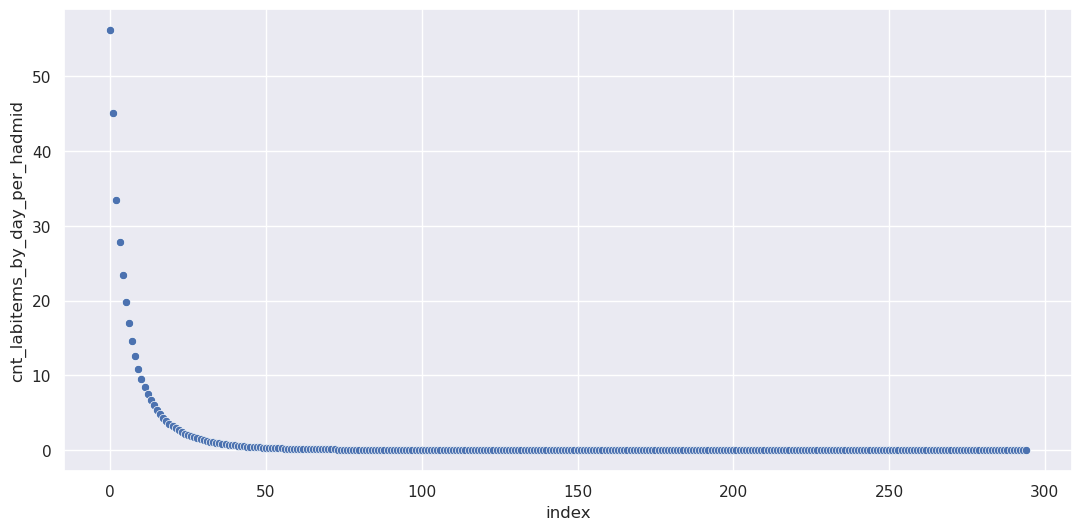

In [43]:
sns.set(rc={'figure.figsize':(13,6)})
df_cnt_labitems_by_day_per_hadmid = pd.DataFrame(bucket_elements, columns=["cnt_labitems_by_day_per_hadmid"]).reset_index()
sns.scatterplot(x="index", y="cnt_labitems_by_day_per_hadmid", data=df_cnt_labitems_by_day_per_hadmid)

## Build timestep

In [44]:
def add_timestep_per_hadmid(df_grouped_by_hadmid: pd.DataFrame):
    interval_hour = 24  # chosen interval
    df_grouped_by_hadmid = df_grouped_by_hadmid.sort_values(by="CHARTTIME")

    st = df_grouped_by_hadmid.CHARTTIME.iloc[0]  # st <- start time
    et = df_grouped_by_hadmid.CHARTTIME.iloc[-1]  # et <- end time
    st = datetime.strptime(f"{st.year}-{st.month}-{st.day} {st.hour//interval_hour*interval_hour:2}:00:00", "%Y-%m-%d %H:%M:%S")
    et = datetime.strptime(f"{et.year}-{et.month}-{et.day} {(((et.hour//interval_hour)+1)*interval_hour)-1:2}:59:59", "%Y-%m-%d %H:%M:%S")

    interval = timedelta(hours=interval_hour)

    dfx = df_grouped_by_hadmid.copy()
    dfx.insert(len(dfx.columns), "TIMESTEP", np.NaN)
    
    timestep = 0
    while st < et:
        mask = (st <= dfx.CHARTTIME) & (dfx.CHARTTIME <= st + interval)
        if len(dfx.loc[mask]) > 0:
            dfx.loc[mask, 'TIMESTEP'] = timestep
            timestep += 1
        st += interval

    return dfx

HADM_ID = 100001
add_timestep_per_hadmid(grouped_by_hadmid.get_group(HADM_ID))

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
199,22441082,58526,100001.0,51254,2117-09-11 08:22:00,1.1,1.10,%,abnormal,0.0,-1.615526,0.0
220,22441086,58526,100001.0,51279,2117-09-11 08:22:00,4.58,4.58,m/uL,NaN,0.0,-0.233590,0.0
45,22441067,58526,100001.0,50902,2117-09-11 08:22:00,101,101.00,mEq/L,NaN,0.0,-0.564238,0.0
213,22441085,58526,100001.0,51277,2117-09-11 08:22:00,13.6,13.60,%,NaN,0.0,-0.593931,0.0
204,22441084,58526,100001.0,51265,2117-09-11 08:22:00,466,466.00,K/uL,abnormal,0.0,2.788484,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18,22441321,58526,100001.0,50882,2117-09-17 05:45:00,23,23.00,mEq/L,NaN,0.0,-1.112538,6.0
87,22441325,58526,100001.0,50960,2117-09-17 05:45:00,1.9,1.90,mg/dL,NaN,0.0,-0.529679,6.0
58,22441323,58526,100001.0,50912,2117-09-17 05:45:00,2.3,2.30,mg/dL,abnormal,0.0,6.773772,6.0
72,22441324,58526,100001.0,50931,2117-09-17 05:45:00,118,118.00,mg/dL,abnormal,0.0,3.000165,6.0


In [45]:
df_grouped_by_hadmid_timestep_added = grouped_by_hadmid.apply(add_timestep_per_hadmid)
df_grouped_by_hadmid_timestep_added

ROW_ID  SUBJECT_ID   HADM_ID  ITEMID           CHARTTIME  \
HADM_ID                                                                         
100001.0 199       22441082       58526  100001.0   51254 2117-09-11 08:22:00   
         220       22441086       58526  100001.0   51279 2117-09-11 08:22:00   
         45        22441067       58526  100001.0   50902 2117-09-11 08:22:00   
         213       22441085       58526  100001.0   51277 2117-09-11 08:22:00   
         204       22441084       58526  100001.0   51265 2117-09-11 08:22:00   
...                     ...         ...       ...     ...                 ...   
199999.0 21445598  19961560       40370  199999.0   51250 2136-04-10 01:28:00   
         21445487  19961548       40370  199999.0   50902 2136-04-10 01:28:00   
         21445590  19961559       40370  199999.0   51249 2136-04-10 01:28:00   
         21445545  19961555       40370  199999.0   51006 2136-04-10 01:28:00   
         21445624  19961562       40370  199999.0   51277 2136-04-10 01:28:00   

                  VALUE  VALUENUM VALUEUOM      FLAG  CATAGORY  \
HADM_ID                                                          
100001.0 199        1.1      1.10        %  abnormal       0.0   
         220       4.58      4.58     m/uL       NaN       0.0   
         45         101    101.00    mEq/L       NaN       0.0   
         213       13.6     13.60        %       NaN       0.0   
         204        466    466.00     K/uL  abnormal       0.0   
...                 ...       ...      ...       ...       ...   
199999.0 21445598    92     92.00       fL       NaN       0.0   
         21445487   102    102.00    mEq/L       NaN       0.0   
         21445590  33.2     33.20        %       NaN       0.0   
         21445545    16     16.00    mg/dL       NaN       0.0   
         21445624  14.3     14.30        %       NaN       0.0   

                   VALUENUM_Z-SCORED  TIMESTEP  
HADM_ID                                         
100001.0 199               -1.615526       0.0  
         220               -0.233590       0.0  
         45                -0.564238       0.0  
         213               -0.593931       0.0  
         204                2.788484       0.0  
...                              ...       ...  
199999.0 21445598           0.563850       6.0  
         21445487          -0.272444       6.0  
         21445590          -0.111115       6.0  
         21445545           0.603423       6.0  
         21445624           0.215884       6.0  

[21445662 rows x 12 columns]

In [46]:
HADM_ID = 199765
df_grouped_by_hadmid_timestep_added[df_grouped_by_hadmid_timestep_added.HADM_ID == HADM_ID]

ROW_ID  SUBJECT_ID   HADM_ID  ITEMID           CHARTTIME  \
HADM_ID                                                                       
199765.0 21389065  198768         313  199765.0   50908 2139-07-26 14:53:00   
         21389095  198774         313  199765.0   50960 2139-07-26 14:53:00   
         21389195  198788         313  199765.0   51265 2139-07-26 14:53:00   
         21389188  198787         313  199765.0   51250 2139-07-26 14:53:00   
         21389181  198786         313  199765.0   51249 2139-07-26 14:53:00   
...                   ...         ...       ...     ...                 ...   
         21389222  199044         313  199765.0   51279 2139-08-07 04:40:00   
         21389124  199035         313  199765.0   50983 2139-08-07 04:40:00   
         21389112  199034         313  199765.0   50971 2139-08-07 04:40:00   
         21389092  199032         313  199765.0   50960 2139-08-07 04:40:00   
         21389037  199027         313  199765.0   50882 2139-08-07 04:40:00   

                  VALUE  VALUENUM VALUEUOM      FLAG  CATAGORY  \
HADM_ID                                                          
199765.0 21389065   1.3      1.30        %       NaN       0.0   
         21389095   2.0      2.00    mg/dL       NaN       0.0   
         21389195   201    201.00     K/uL       NaN       0.0   
         21389188    89     89.00       fL       NaN       0.0   
         21389181  32.6     32.60        %       NaN       0.0   
...                 ...       ...      ...       ...       ...   
         21389222  3.91      3.91     m/uL  abnormal       0.0   
         21389124   142    142.00    mEq/L       NaN       0.0   
         21389112   4.1      4.10    mEq/L       NaN       0.0   
         21389092   2.0      2.00    mg/dL       NaN       0.0   
         21389037    27     27.00    mEq/L       NaN       0.0   

                   VALUENUM_Z-SCORED  TIMESTEP  
HADM_ID                                         
199765.0 21389065          -0.847418       0.0  
         21389095          -0.120601       0.0  
         21389195          -0.755070       0.0  
         21389188          -0.174744       0.0  
         21389181          -0.695472       0.0  
...                              ...       ...  
         21389222          -2.074247       8.0  
         21389124           1.001278       8.0  
         21389112           0.037039       8.0  
         21389092          -0.120601       8.0  
         21389037           0.377594       8.0  

[265 rows x 12 columns]

In [47]:
df_labevents = df_labevents.merge(df_grouped_by_hadmid_timestep_added[['ROW_ID', 'TIMESTEP']], how='left', on='ROW_ID', copy=False)
df_labevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN,0.0,1.514176,0.0
1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN,0.0,-1.200442,0.0
2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN,0.0,1.285326,0.0
3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN,0.0,0.227316,6.0
4,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.0,mEq/L,abnormal,0.0,5.890828,0.0


<Axes: ylabel='Frequency'>

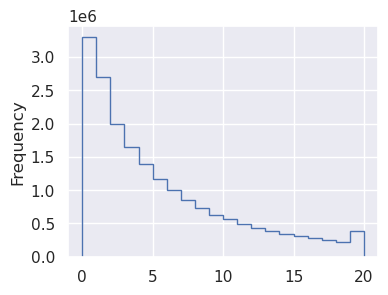

In [48]:
df_labevents.TIMESTEP.plot(kind='hist', bins=20, range=(0, 20), histtype="step", figsize=(4, 3))

## Construct edges

In [49]:
df_labevents.sort_values(by=["HADM_ID", "ITEMID"], inplace=True)

# Perform merge to obtain the edges from HADM_ID and ITEMID:
ratings_hadm_id = pd.merge(df_labevents['HADM_ID'], unique_hadm_id, left_on='HADM_ID', right_on='HADM_ID', how='left')
ratings_item_id = pd.merge(df_labevents['ITEMID'], unique_item_id, left_on='ITEMID', right_on='ITEMID', how='left')

ratings_hadm_id = torch.from_numpy(ratings_hadm_id['mappedID'].values)
ratings_item_id = torch.from_numpy(ratings_item_id['mappedID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_hadm_to_item = torch.stack([ratings_hadm_id, ratings_item_id], dim=0)
print(edge_index_hadm_to_item)

tensor([[    0,     0,     0,  ..., 58975, 58975, 58975],
        [   13,    61,    63,  ...,   697,   715,   715]])


In [52]:
df_labevents.describe()
# df_labevents.to_csv(os.path.join(path_dataset, "LABEVENTS_NEW.csv.gz"))  # DONE

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,VALUENUM,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
count,2.144566e+07,2.144566e+07,2.144566e+07,2.144566e+07,2.011531e+07,2.144566e+07,2.144566e+07,2.144566e+07
mean,1.452475e+07,3.361060e+04,1.499737e+05,5.103411e+04,7.662884e+01,3.172838e-01,inf,8.558249e+00
std,8.171790e+06,2.807771e+04,2.886325e+04,1.986901e+02,4.880162e+03,9.097766e+00,NaN,1.309219e+01
min,1.000000e+00,2.000000e+00,1.000010e+05,5.080000e+04,-4.140000e+02,0.000000e+00,-1.927052e+02,0.000000e+00
25%,7.389627e+06,1.184600e+04,1.251170e+05,5.086700e+04,4.400000e+00,0.000000e+00,-1.029072e+00,1.000000e+00
50%,1.485899e+07,2.402300e+04,1.498600e+05,5.097000e+04,1.900000e+01,0.000000e+00,0.000000e+00,4.000000e+00
75%,2.178973e+07,5.387800e+04,1.750310e+05,5.124900e+04,6.000000e+01,0.000000e+00,1.408004e+00,1.100000e+01
max,2.790765e+07,9.999900e+04,1.999990e+05,5.153700e+04,1.104000e+07,1.354000e+03,inf,2.910000e+02


# New labevents

In [3]:
df_new_labevents = pd.read_csv(os.path.join(path_dataset, "LABEVENTS_NEW.csv.gz"))
df_new_labevents.head()

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
0,0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN,0.0,1.514176,0.0
1,1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN,0.0,-1.200442,0.0
2,2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN,0.0,1.285326,0.0
3,3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN,0.0,0.227316,6.0
4,4,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.0,mEq/L,abnormal,0.0,5.890828,0.0


## Merging repeat edges

- single admission
- single timestep
- multiple labitem
- multiple entries per labitem may exist!

In [4]:
gb_hadmid = df_new_labevents.groupby("HADM_ID")
gb_hadmid.get_group(100001)

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
0,0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.900,mmol/L,NaN,0.0,1.514176,0.0
1,1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.000,IU/L,NaN,0.0,-1.200442,0.0
2,2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.000,IU/L,NaN,0.0,1.285326,0.0
3,3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.000,mEq/L,NaN,0.0,0.227316,6.0
4,4,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.000,mEq/L,abnormal,0.0,5.890828,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,259,22441266,58526,100001.0,51498,2117-09-14 10:08:00,1.006,1.006,,NaN,0.0,-1.409170,3.0
260,260,22441097,58526,100001.0,51516,2117-09-11 08:53:00,2,2.000,#/hpf,NaN,0.0,0.683148,0.0
261,261,22441178,58526,100001.0,51516,2117-09-12 08:41:00,1,1.000,#/hpf,NaN,0.0,-0.100556,1.0
262,262,22441226,58526,100001.0,51516,2117-09-13 08:21:00,2,2.000,#/hpf,NaN,0.0,0.683148,2.0


In [5]:
df_curr_hadmid = gb_hadmid.get_group(100001)

max_timestep = df_curr_hadmid.TIMESTEP.max()

df_curr_hadmid_curr_timestep = df_curr_hadmid[df_curr_hadmid.TIMESTEP == 1]

sr_itemid_value_counts = df_curr_hadmid_curr_timestep.ITEMID.value_counts()
sr_itemid_repeat = sr_itemid_value_counts[sr_itemid_value_counts > 1]

df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == sr_itemid_repeat.index[-1]]

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
169,169,22441164,58526,100001.0,51222,2117-09-12 03:36:00,11.3,11.3,g/dL,abnormal,0.0,-1.826450,1.0
170,170,22441207,58526,100001.0,51222,2117-09-12 23:15:00,11.2,11.2,g/dL,abnormal,0.0,-1.904345,1.0


In [6]:
perserve_entry_value = df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == sr_itemid_repeat.index[-1]]["VALUENUM_Z-SCORED"].mean()
perserve_entry_value

-1.8653975104340403

### 2 choices

- use mean value
- use last entry

After thinking, I decided to use last entry. Because it represents for the hadm's last situation at current timestep!

In [7]:
perserve_entry_rowid = df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == sr_itemid_repeat.index[-1]].sort_values(by="CHARTTIME").ROW_ID.iloc[-1]
deprecate_entry_rowid = df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == sr_itemid_repeat.index[-1]].sort_values(by="CHARTTIME").ROW_ID.iloc[0:-1]

# df_new_labevents.loc[df_new_labevents.ROW_ID == perserve_entry_rowid, "VALUENUM_Z-SCORED"] = perserve_entry_value
df_new_labevents[df_new_labevents.ROW_ID == perserve_entry_rowid]

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
170,170,22441207,58526,100001.0,51222,2117-09-12 23:15:00,11.2,11.2,g/dL,abnormal,0.0,-1.904345,1.0


In [8]:
deprecate_entry_rowid

169    22441164
Name: ROW_ID, dtype: int64

In [ ]:
drop_indexs = []
for hadm_id in tqdm_notebook(df_new_labevents.HADM_ID.unique()):
    df_curr_hadmid = df_new_labevents[df_new_labevents.HADM_ID == hadm_id]
    
    for timestep in range(int(df_curr_hadmid.TIMESTEP.max()) + 1):
        df_curr_hadmid_curr_timestep = df_curr_hadmid[df_curr_hadmid.TIMESTEP == timestep]
        
        sr_itemid_value_counts = df_curr_hadmid_curr_timestep.ITEMID.value_counts()
        sr_itemid_repeat = sr_itemid_value_counts[sr_itemid_value_counts > 1]
        
        for itemid_repeat in list(sr_itemid_repeat.index):
            deprecate_entry_rowid = df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == itemid_repeat].sort_values(by="CHARTTIME").ROW_ID.iloc[0:-1]
            deprecate_entry_index = list(deprecate_entry_rowid.index)
            drop_indexs.extend(deprecate_entry_index)

len(drop_indexs)

  0%|          | 0/58151 [00:00<?, ?it/s]

## post-check

In [3]:
df_new_labevents_remove_duplicate_edges = pd.read_csv(os.path.join(path_dataset, "LABEVENTS_NEW_remove_duplicate_edges.csv.gz"))
df_new_labevents_remove_duplicate_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15309100 entries, 0 to 15309099
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0.1       int64  
 1   Unnamed: 0         int64  
 2   ROW_ID             int64  
 3   SUBJECT_ID         int64  
 4   HADM_ID            float64
 5   ITEMID             int64  
 6   CHARTTIME          object 
 7   VALUE              object 
 8   VALUENUM           float64
 9   VALUEUOM           object 
 10  FLAG               object 
 11  CATAGORY           float64
 12  VALUENUM_Z-SCORED  float64
 13  TIMESTEP           float64
dtypes: float64(5), int64(5), object(4)
memory usage: 1.6+ GB


In [11]:
df_new_labevents_remove_duplicate_edges.tail()

,Unnamed: 0.1,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
15309095,21445657,21445657,19961424,40370,199999.0,51493,2136-04-06 01:25:00,1,1.000,#/hpf,NaN,0.0,0.475245,2.0
15309096,21445658,21445658,19961375,40370,199999.0,51498,2136-04-04 22:45:00,1.009,1.009,,NaN,0.0,-0.958555,0.0
15309097,21445659,21445659,19961425,40370,199999.0,51498,2136-04-06 01:25:00,1.022,1.022,,NaN,0.0,0.994113,2.0
15309098,21445660,21445660,19961376,40370,199999.0,51516,2136-04-04 22:45:00,7,7.000,#/hpf,abnormal,0.0,4.601665,0.0
15309099,21445661,21445661,19961426,40370,199999.0,51516,2136-04-06 01:25:00,3,3.000,#/hpf,NaN,0.0,1.466851,2.0


In [14]:
gb_hadmid = df_new_labevents_remove_duplicate_edges.groupby("HADM_ID")
df_curr_hadmid = gb_hadmid.get_group(199998)

max_timestep = df_curr_hadmid.TIMESTEP.max()

df_curr_hadmid_curr_timestep = df_curr_hadmid[df_curr_hadmid.TIMESTEP == 0]

sr_itemid_value_counts = df_curr_hadmid_curr_timestep.ITEMID.value_counts()
sr_itemid_repeat = sr_itemid_value_counts[sr_itemid_value_counts > 1]
sr_itemid_value_counts

ITEMID
50868    1
51249    1
51506    1
51498    1
51491    1
51487    1
51466    1
51464    1
51301    1
51279    1
51277    1
51275    1
51274    1
51265    1
51250    1
51248    1
50882    1
51237    1
51222    1
51221    1
51006    1
50983    1
50971    1
50970    1
50960    1
50931    1
50920    1
50912    1
50902    1
50893    1
51514    1
Name: count, dtype: int64